In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import os
from sklearn import linear_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize
import pickle
from gensim.models import KeyedVectors
from keras.applications.inception_v3 import preprocess_input

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Loading the Data

In [10]:
trainDF = pd.read_csv("./input/avito-demand-prediction/train.csv")
testDF = pd.read_csv("./input/avito-demand-prediction/test.csv")

# Corrupted images in the training set. 
badImgs = ["4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c",
           "b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae",
           "60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83",
           "8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58"]

trainDF = trainDF[~trainDF["image"].isin(badImgs)]

trainDF.head()
#testDF.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


## Preprocessing

In [11]:
features = ["image"]
selectFrame = trainDF[features+["deal_probability"]].dropna(how='any')


selectFrame = selectFrame[selectFrame["description"].map(len) <= 200]
selectFrame.loc[:,'region'], mapping_index_region = pd.Series(selectFrame['region']).factorize()
reverseRegionMap = {mapping_index_region[i]: i for i in range(0, len(mapping_index_region))}
#testDF['city'] = testDF['city'].map(reverseCityMap)

#selectFrame.loc[:,"price"] = selectFrame["price"].fillna(0)
#selectFrame.loc[:,"description"] = selectFrame["description"].fillna("")
selectFrame.shape

(245169, 6)

In [24]:
imagePath = "./input/avito-demand-prediction/train_jpg/data/competition_files/train_jpg/"
imageExt = ".jpg"
inpShape = (299,299,3)
max_features = 30000
maxlen = 200
embed_size = 300

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, sFrame ,batch_size=30,shuffle=True):
        'Initialization'
        self.sFrame = sFrame
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.descTokenizer = Tokenizer(num_words=max_features)
        
        # Takes some time upon initilization of the data generator. 
        self.descTokenizer.fit_on_texts(sFrame["description"]) 

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.sFrame.shape[0] / self.batch_size))
    
    def makeEmbeddingMatrix(self):
        def getEmbedding(x):
            if x in ru_model:
                return ru_model[x]
            else:
                return None

        word_index = self.descTokenizer.word_index
        embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
        for word, i in word_index.items():
            embedding_vector = getEmbedding(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
                
        return embedding_matrix

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        sampleFrame =  self.sFrame[index*self.batch_size:(index+1)*self.batch_size]
        #sampleFrame =  self.sFrame.sample(n=self.batch_size)
        
        # Process Images
        imgURIs     = sampleFrame["image"].map(lambda x: imagePath+x+imageExt)
        imgReads    = imgURIs.map(imread)
        imgReads    = imgReads.map(lambda img : preprocess_input(resize(img,inpShape)))
        outImgs     = np.hstack(imgReads.as_matrix()).reshape((self.batch_size,inpShape[0],inpShape[1],inpShape[2]))
        
        # Process Descriptions
        descTokens =  pad_sequences(self.descTokenizer.texts_to_sequences(sampleFrame["description"]),maxlen = maxlen )
        titTokens  =  pad_sequences(self.descTokenizer.texts_to_sequences(sampleFrame["title"]),maxlen = maxlen )

        return [sampleFrame["price"],descTokens,outImgs,sampleFrame["region"],titTokens], sampleFrame["deal_probability"]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.sFrame = self.sFrame.sample(frac=1)
            
dataGen = DataGenerator(selectFrame)
embedding_matrix = dataGen.makeEmbeddingMatrix()

## Modeling

In [29]:
incpetionModel = InceptionV3(weights='imagenet', classes=1000,include_top=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, None, None, 3 864         input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_565 (BatchN (None, None, None, 3 96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, None, None, 3 0           batch_normalization_565[0][0]    
__________________________________________________________________________________________________
conv2d_566

In [37]:
ifeat1 = Model(incpetionModel.input, incpetionModel.get_layer("conv2d_566").output)
ifeat1.trainable = False

In [38]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D,BatchNormalization,Flatten
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


# Description Input
desInp = Input(shape=(maxlen, )) 
emb = Embedding(len(embedding_matrix), embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(desInp)
d = LSTM(maxlen, return_sequences=True,name='lstm_layer')(emb)
d = GlobalMaxPool1D()(d)

# Title Input
titInp = Input(shape=(maxlen, )) 
emb2 = Embedding(len(embedding_matrix), embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False)(titInp)
t = LSTM(maxlen, return_sequences=True,name='lstm_layer2_1')(emb2)
t = GlobalMaxPool1D()(t)

# Price Input
priceInp = Input(shape=(1, ))
y = Dense(10,activation="sigmoid")(priceInp)

# Region Input 
regionInp = Input(shape=(1, ))
r = Dense(len(mapping_index_region),activation="sigmoid")(regionInp)

# Image Input
imgInp = Input(shape=(299,299,3,))
z = Flatten()(ifeat1(imgInp))

x = Concatenate(axis=-1)([d,z])
x = Dense(400, activation="sigmoid")(x)
x = Concatenate(axis=-1)([x,t])
x = Dense(400, activation="sigmoid")(x)
x = Concatenate(axis=-1)([x,y])
x = Dense(400, activation="sigmoid")(x)
x = Concatenate(axis=-1)([x,r])
x = Dense(400, activation="sigmoid")(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[priceInp,desInp,imgInp,regionInp,titInp], outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam')

model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[341256,400]
	 [[Node: dense_40/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_40/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_40/kernel, dense_40/random_uniform)]]

Caused by op 'dense_40/kernel/Assign', defined at:
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-734301ebbb91>", line 35, in <module>
    x = Dense(400, activation="sigmoid")(x)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\engine\topology.py", line 592, in __call__
    self.build(input_shapes[0])
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\layers\core.py", line 842, in build
    constraint=self.kernel_constraint)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\engine\topology.py", line 416, in add_weight
    constraint=constraint)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\backend\tensorflow_backend.py", line 395, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 56, in assign
    use_locking=use_locking, name=name)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[341256,400]
	 [[Node: dense_40/kernel/Assign = Assign[T=DT_FLOAT, _class=["loc:@dense_40/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_40/kernel, dense_40/random_uniform)]]


## Training 


In [34]:
hist = model.fit_generator(dataGen,steps_per_epoch=len(dataGen),epochs=5, verbose=1, workers=10, max_queue_size=30)

Epoch 1/5


C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ResourceExhaustedError: OOM when allocating tensor with shape[341256,400]
	 [[Node: training_3/Adam/mul_63 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam_4/beta_2/read, training_3/Adam/Variable_38/read)]]
	 [[Node: loss_4/mul/_25221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4773_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'training_3/Adam/mul_63', defined at:
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-fb9fbbae10a1>", line 1, in <module>
    hist = model.fit_generator(dataGen,steps_per_epoch=len(dataGen),epochs=5, verbose=1, workers=10, max_queue_size=30)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\engine\training.py", line 2080, in fit_generator
    self._make_train_function()
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\engine\training.py", line 990, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\keras\optimizers.py", line 467, in get_updates
    v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\variables.py", line 754, in _run_op
    return getattr(ops.Tensor, operator)(a._AsTensor(), *args)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\math_ops.py", line 894, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1117, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2725, in _mul
    "Mul", x=x, y=y, name=name)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[341256,400]
	 [[Node: training_3/Adam/mul_63 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Adam_4/beta_2/read, training_3/Adam/Variable_38/read)]]
	 [[Node: loss_4/mul/_25221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4773_loss_4/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


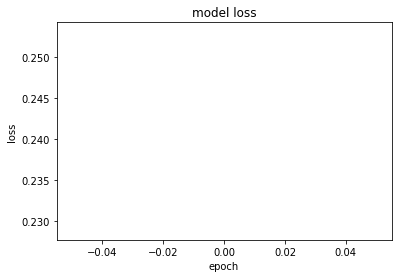

In [26]:
history = hist

# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [30]:
model.save_weights("fullModel200desc.h5")

In [28]:
z = []
for b in dataGen:
    z = b
    break
model.predict(z[0])

C:\Users\Andre\Anaconda3\envs\GreatEnv\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


array([[0.7068723 ],
       [0.3844442 ],
       [0.21511969],
       [0.47193283],
       [0.30232438],
       [0.21447663],
       [0.43731254],
       [0.45060337],
       [0.43654516],
       [0.7861788 ],
       [0.39596084],
       [0.31302848],
       [0.22435673],
       [0.22836034],
       [0.2467949 ],
       [0.8563656 ],
       [0.856834  ],
       [0.2851278 ],
       [0.38050124],
       [0.7471454 ],
       [0.75038964],
       [0.22177394],
       [0.22196275],
       [0.33452576],
       [0.3270043 ],
       [0.25008255],
       [0.772839  ],
       [0.29439136],
       [0.3824447 ],
       [0.24160916],
       [0.32894403],
       [0.38302404]], dtype=float32)

In [29]:
z[1]

1451055    0.17360
662493     0.76786
584977     0.42888
986285     0.40000
1267524    0.27307
36817      0.12734
928183     0.33973
428612     0.22561
454236     0.71647
868584     0.80323
983279     0.13107
1189447    0.82668
1143510    0.27307
1306639    0.15487
1026150    0.22382
197800     0.12136
1088843    0.86521
238047     0.20315
826965     0.32792
564770     0.76786
760925     0.11494
384042     0.12396
909341     0.29692
1378438    0.14209
205331     0.17849
1144855    0.19661
1082124    0.86520
403028     0.21678
1293307    0.14378
1021512    0.13301
1442745    0.38925
1255309    0.30085
Name: deal_probability, dtype: float64